Predict whether posts come from depression or suicide thread

In [1]:
import pandas as pd
import numpy as np

from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import plot_confusion_matrix

import seaborn as sns #only responded to pip install (not pip3 install or conda install)
import matplotlib.pyplot as plt
from nltk.corpus import stopwords


In [2]:
df_suicide_posts = pd.read_csv('suicidewatch_posts.csv')
df_depression_posts = pd.read_csv('depression_posts.csv')

In [3]:
# Create column 'Suicide', intialize with 1
df_suicide_posts['Suicide'] = 1
df_suicide_posts['Depression'] = np.nan

print(len(df_suicide_posts)) # Check
df_suicide_posts.head(1) # Check

4447


,title,score,p_id,subreddit,url,num_comments,body,p_timestamp,c_id,comment,c_timestamp,Post_Reply,Time_to_Comment,Suicide,Depression
0,New wiki on how to avoid accidentally encourag...,596,cz6nfd,SuicideWatch,https://www.reddit.com/r/SuicideWatch/comments...,157,We've been seeing a worrying increase in pro-s...,2019-09-03 18:49:51,eyx1qcc,I'm sorry did you say suicide fetishists? As i...,2019-09-03 23:34:05,Y,0 days 04:44:14.000000000,1,NaN


In [4]:
# Create column 'Depression', intialize with 0
df_depression_posts['Suicide'] = np.nan
df_depression_posts['Depression'] = 0

print(len(df_depression_posts)) # Check
df_depression_posts.head(1) # Check

4035


,title,score,p_id,subreddit,url,num_comments,body,p_timestamp,c_id,comment,c_timestamp,Post_Reply,Time_to_Comment,Suicide,Depression
0,Regular Check-In Post,970,cml6ni,depression,https://www.reddit.com/r/depression/comments/c...,5523,Welcome to /r/depression's check-in post - a p...,2019-08-06 06:12:33,ew4joli,I gave in to my depression and stayed home ins...,2019-08-06 20:21:04,Y,0 days 14:08:31.000000000,NaN,0


In [5]:
# Merge the two datasets
frames = [df_depression_posts, df_suicide_posts]
df_merged = pd.concat(frames)

print(len(df_merged)) # Check
df_merged.head(1) # Check

8482


,title,score,p_id,subreddit,url,num_comments,body,p_timestamp,c_id,comment,c_timestamp,Post_Reply,Time_to_Comment,Suicide,Depression
0,Regular Check-In Post,970,cml6ni,depression,https://www.reddit.com/r/depression/comments/c...,5523,Welcome to /r/depression's check-in post - a p...,2019-08-06 06:12:33,ew4joli,I gave in to my depression and stayed home ins...,2019-08-06 20:21:04,Y,0 days 14:08:31.000000000,NaN,0.0


In [6]:
# Split into train and test set
df_merged['Target'] = df_merged['Suicide'].combine_first(df_merged['Depression'])

df_merged['Target'].value_counts() # Check
df_merged.head(3)

,title,score,p_id,subreddit,url,num_comments,body,p_timestamp,c_id,comment,c_timestamp,Post_Reply,Time_to_Comment,Suicide,Depression,Target
0,Regular Check-In Post,970,cml6ni,depression,https://www.reddit.com/r/depression/comments/c...,5523,Welcome to /r/depression's check-in post - a p...,2019-08-06 06:12:33,ew4joli,I gave in to my depression and stayed home ins...,2019-08-06 20:21:04,Y,0 days 14:08:31.000000000,NaN,0.0,0.0
1,Regular Check-In Post,970,cml6ni,depression,https://www.reddit.com/r/depression/comments/c...,5523,Welcome to /r/depression's check-in post - a p...,2019-08-06 06:12:33,ewejn04,Currently experiencing: Extreme sadness (but c...,2019-08-09 07:49:31,Y,3 days 01:36:58.000000000,NaN,0.0,0.0
2,Regular Check-In Post,970,cml6ni,depression,https://www.reddit.com/r/depression/comments/c...,5523,Welcome to /r/depression's check-in post - a p...,2019-08-06 06:12:33,ew6orjt,i’m just too scared to kill myself. i wish i c...,2019-08-07 14:34:33,Y,1 days 08:22:00.000000000,NaN,0.0,0.0


In [7]:
# print(list(df_merged['body'])[:5])

In [8]:
sw = stopwords.words('english')

# Replace '\n' and '\\' with ''
df_merged['comment'] = df_merged['comment'].astype(str).str.replace('\n', '').str.replace('\\', '')

# Remove stopwords
df_merged['comment_sw'] = df_merged['comment'].apply(lambda x: ' '.join([word for word in x.split() if word not in (sw)])).astype(str)

# Remove special characters; make all characters lowercase
df_merged['comment_sw_p'] = df_merged['comment_sw'].str.replace('[^\w\s]', '').str.lower()

# Create boolean for deleted comments
df_merged['deleted'] = np.where(df_merged['comment']=='[deleted]', 'Y', 'N')

# Create column with comment length
df_merged['comment_length'] = 0

for i in range(len(df_merged)):
    df_merged['comment_length'].iloc[i] = len(df_merged['comment'].iloc[i].split(' '))
    
df_merged['comment_length'] = np.where(df_merged['deleted']=='Y', np.NaN, df_merged['comment_length'])
df_merged.head(1)

C:\Users\Hannah\Anaconda3\lib\site-packages\pandas\core\indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


,title,score,p_id,subreddit,url,num_comments,body,p_timestamp,c_id,comment,c_timestamp,Post_Reply,Time_to_Comment,Suicide,Depression,Target,comment_sw,comment_sw_p,deleted,comment_length
0,Regular Check-In Post,970,cml6ni,depression,https://www.reddit.com/r/depression/comments/c...,5523,Welcome to /r/depression's check-in post - a p...,2019-08-06 06:12:33,ew4joli,I gave in to my depression and stayed home ins...,2019-08-06 20:21:04,Y,0 days 14:08:31.000000000,NaN,0.0,0.0,I gave depression stayed home instead going ex...,i gave depression stayed home instead going ex...,N,92.0


In [9]:
# Train and run Logistic Regression model

# Sublinear tf scaling: https://nlp.stanford.edu/IR-book/html/htmledition/sublinear-tf-scaling-1.html
# min_df: When building the vocabulary ignore terms that have a document frequency strictly lower than the given threshold. 
# norm: cosine similarity between two vectors is their dot product when l2 norm has been applied
# ngram_range: an ngram_range of (1, 1) means only unigrams, (1, 2) means unigrams and bigrams, and (2, 2) means only bigrams
tfidf = TfidfVectorizer(sublinear_tf = True, min_df = 5, norm = 'l2', ngram_range = (1,2))
features = tfidf.fit_transform(df_merged.comment_sw_p).toarray()
features.shape # Each comment is represented by 6948 features, which are tf-idf scores for various unigrams and bigrams

(8482, 6948)

In [10]:
X_train, X_test, y_train, y_test = train_test_split(features, df_merged['Target'], random_state = 42)

In [11]:
y_test.values

array([0., 1., 0., ..., 0., 1., 1.])

[[614 399]
 [322 786]]
Confusion matrix, without normalization
[[614 399]
 [322 786]]
Normalized confusion matrix
[[0.61 0.39]
 [0.29 0.71]]


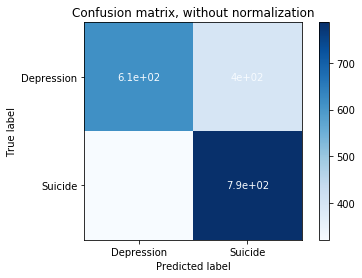

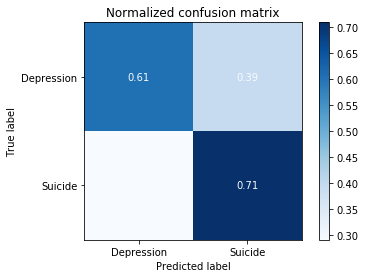

LogisticRegression


,model_name,fold_index,accuracy
0,LogisticRegression,0,0.613435
1,LogisticRegression,1,0.614025
2,LogisticRegression,2,0.590802
3,LogisticRegression,3,0.620873
4,LogisticRegression,4,0.616745


In [16]:
# Predict subreddit class based on tf-idf scores using Logistic Regression model
models = [LogisticRegression(penalty = 'l2', random_state = 42, solver = 'liblinear')]
CV = 5
entries = []
class_names = ['Depression', 'Suicide']
for model in models:
    
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    
    conf_matrix = confusion_matrix(y_test, y_pred)
    print (conf_matrix)
    
    np.set_printoptions(precision = 2)
#     fig, ax = plt.subplots(figsize = (5,5))
#     sns.heatmap(conf_matrix, annot = True, fmt = 'd', xticklabels = class_names, yticklabels = class_names)
#     plt.ylabel('Actual')
#     plt.xlabel('Predicted')
#     plt.show()
    
    # Plot non-normalized and normalized confusion matrix
    titles_options = [("Confusion matrix, without normalization", None), ("Normalized confusion matrix", 'true')]
    for title, normalize in titles_options:
        disp = plot_confusion_matrix(model, X_test, y_test, display_labels = class_names, cmap = plt.cm.Blues, normalize = normalize)
        disp.ax_.set_title(title)
        print(title)
        print(disp.confusion_matrix)
    plt.show()
        
    model_name = model.__class__.__name__
    print (model_name)
    
    accuracies = cross_val_score(model, features, df_merged.Target, scoring = 'accuracy', cv = CV) # cross_val_score(estimator, X, y)
    for fold_index, accuracy in enumerate(accuracies):
        entries.append((model_name, fold_index, accuracy))
        
cv_df = pd.DataFrame(entries, columns = ['model_name', 'fold_index','accuracy'])
cv_df

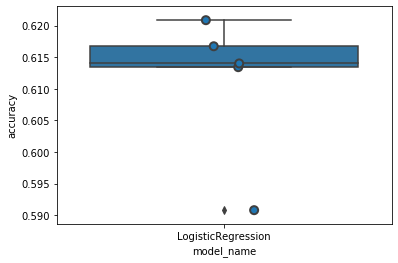

In [13]:
sns.boxplot(x = 'model_name', y = 'accuracy', data = cv_df)
# Stripplot: Draw a scatterplot where one variable is categorical.
sns.stripplot(x = 'model_name', y = 'accuracy', data = cv_df, size = 8, jitter = True, edgecolor = 'gray', linewidth = 2)

Word Embeddings

array([1., 0., 1., ..., 1., 0., 1.])